# @authors:

Fritz poka Toukam 


Ndjekoua Sandjo Jean Thibaut

#Link to the presentation

[link to the slides](https://docs.google.com/presentation/d/1Vbx7MCJtb7leRM5sD0q7WcskLuIyCKBkjLPoj6anU64/edit?usp=sharing)

In [0]:
 %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from copy import copy, deepcopy
import random
from scipy.stats import norm
from sklearn.utils.random import sample_without_replacement
from scipy.special import softmax

In [0]:
def get_best_actions(q,nb_actions):
  """
    get the best actions for the epsilon greeedy strategy given the vector q
    @input 
    -q: array of shape (nb_items,) representing the weigth associated to each action
    -nb_actions: number of actions to be choosen

    @output
    -actions: array of length (nb_actions,) representing the best actions proposed to the user
    
  """
  best_actions = np.argsort(q)[::-1][:nb_actions]
  return best_actions

In [0]:
np.set_printoptions(precision=2)

#Amazon Environment

#Reward
Rewrard of a single item **i** related to user **u**:


$ reward(u,i) = (u.i)*d*price*\frac{1}{p}$


Rewrard of **n** items related to user **u**:

$rewards(u,n_i) = \sum_{i=1}^{n_i} reward(u,i)$

where:

 * **u** is the user feature vector
 * **i** is the item feature vector
 * **d** is the disponibility of the item (in the stock)
 * **price** is the price of item **i**
 * **p** is the number of times user **u** has purcharsed item **i** ( We decided not to limit the number of items proposed to a user. We can propose an item many times to a user, but with a decreasing reward. Same thing with the stock.)

**NOTE** at each step, with probability $ 1- epsilon$ **fixed** a user can buy an item, and with probability $epsilon$ he will buy nothing. 

the probability of an item to be bougth is proportional to the reward related to that item.

In [0]:
class Amazon_environment:
    """ A rating environment for amazon recommender system.
        User and items are represented by points in R^k
        items_features  is the number of features that carachterizes each item

        actions: Recommend nb_items items for a given user among all th items 
    """

    def __init__(self, nb_users=10, nb_items=20,items_featues=2, 
                 internal_embedding_size=3,nb_actions = 2,
                 displayed_users_embedding_size=2,
                 displayed_items_embedding_size=2,
                 noise_size=3,epsilon=0.2,
                 seed=None):
        self.nb_users = nb_users
        self.nb_actions = nb_actions
        self.nb_items = nb_items
        self.items_featues = items_featues
        self.epsilon = epsilon
        self.internal_embedding_size = internal_embedding_size
        self.displayed_users_embedding_size = displayed_users_embedding_size
        self.displayed_items_embedding_size = displayed_items_embedding_size
        self.noise_size = noise_size
        self._rng = np.random.RandomState(seed)
        
        self.action_size = self.nb_items
        self.sampling_limit = nb_users * nb_items
        self.user_mean = np.ones(self.internal_embedding_size)
        self.user_var = np.ones(self.internal_embedding_size)
        self.item_mean = np.ones(self.internal_embedding_size)
        self.item_var = np.ones(self.internal_embedding_size)
        self.users_embedding = None
        self.items_embedding = None
        self.user_item_history = None
        self.done = False

    def get_bought_item(self,epsilon,rewards,actions):
        """
        -with probability epsilon, user does not buy any item, and with 1-epsilon he buys an item.
        -an item is bougth following a probibility proportional to rewards associated to each item.
        """
        a = -1
        proba = np.random.rand() 
        if proba > epsilon:
         probabilities = softmax(rewards)
         a = np.random.choice(actions,size=1,p = probabilities)[0]
        return a


    def step(self, actions):
        # check if behind done
        if self.done: #self.user_item_history.sum() >= self.sampling_limit:
            print("You are calling step after it return done=True.\n"
                  "You should reset the environment.")

        assert len(actions) == self.nb_actions #make sure the user actually chosed the correct number of actions.
        self.actions = actions
        
        # compute potential rewards
        u_i_h_reciprocal = np.reciprocal(self.user_item_history,dtype=float)
        similarity = self.users_embedding[self.current_user,:]@(self.items_embedding.T)
        disponibility = self.items_features_matrix[:,1] / np.max(self.items_features_matrix[:,1])
        price = self.items_features_matrix[:,0]
        potential_rewards = similarity*price*u_i_h_reciprocal[self.current_user,:]*disponibility
        
        
        optimal_return = np.sum(np.sort(potential_rewards)[::-1][:self.nb_actions])

        # compute reward R_t as a sum of the rewards of the actions given by the agent 
        self.current_rating = potential_rewards[actions]
        self.reward = np.sum(self.current_rating)
        
        bought_item = self.get_bought_item(self.epsilon,self.current_rating,actions)
        if bought_item != -1:
           # mark item as bought
           self.user_item_history[self.current_user,bought_item] += 1
           #columns of items_features_matrix represent the disponibility of the items
           self.items_features_matrix[bought_item,1]-=1

        # compute next state S_{t+1}
        self._next_state()
        # update action space t+1
      

        return self.reward,potential_rewards, self.state, self.done, optimal_return
        
    def init_items_features_matrix(self,nb_items,nb_features):
        price = np.random.randint(low=100,high=1000, size=nb_items)
        price = price/np.max(price) #normalize the price between 0 and 1
        disponibility = np.array([100]*nb_items) 
        matrix = np.array([price,disponibility]).T
        return matrix

  
    def reset(self, seed=None):
        self._rng = np.random.RandomState(seed)
        self.action_size = self.nb_items
        
        # create users and items embedding matrix
        self.users_embedding = abs(self._rng.normal(loc=self.user_mean,
                                                scale=self.user_var,
                                                size=(self.nb_users, self.internal_embedding_size)))
        self.users_embedding = self.users_embedding/np.max(self.users_embedding) #normalize between [0,1] in order to avoid the reward to be too high.
        self.items_embedding = abs(self._rng.normal(loc=self.item_mean,
                                                scale=self.item_var,
                                                size=(self.nb_items, self.internal_embedding_size)))
        self.items_embedding = self.items_embedding/np.max(self.items_embedding)

        #create the matrix of items_features where the first column is the price and the second is the stock 
        self.items_features_matrix = self.init_items_features_matrix(self.nb_items,self.items_featues)

        self.user_item_history = np.ones((self.nb_users, self.nb_items))#will contains how many times each user bougth an item
        self.done = False

        self._next_state()
        return self.state



    
    def _get_variables(self, user, item):
        user_embedding = self.users_embedding[user]
        item_embedding = self.items_embedding[item]
        if self.displayed_users_embedding_size + self.displayed_items_embedding_size > 0:
            variables = np.array([user_embedding[:self.displayed_users_embedding_size],
                                  item_embedding[:self.displayed_items_embedding_size]])

            if self.noise_size > 0:
                noise = self._rng.normal(loc=np.ones(self.noise_size),
                                         scale=np.ones(self.noise_size),
                                         size=self.noise_size)
                variables = np.append(variables, noise)

            return variables

    def _get_new_user(self):
        user = self._rng.randint(0, self.nb_users) 
        return user
  

    def _next_state(self):
        # Pick a user
        self.current_user = self._get_new_user()
        
        self.state =list()
        for item in np.arange(0,self.nb_items,1):
          #Compute variables
           variables = self._get_variables(self.current_user, item)
           self.state.append([self.current_user, item, variables])

#EXPERIMENT FUNCTIONS

In [0]:
"""
runs nb_steps simulations between agent and environment
@input 
 -env: the envirenment
 -agent: the agent used for the simulation
 -nb_steps: number of interactions between agent and environment
 -env_seed: seed for the environment. Since both agent and environment are stochastics, this parameter allow the repeatability of the result
@returns
a disctionary containing regrets and cumulative regrets.  
"""
def run_exp(agent, env, nb_steps, env_seed):
    rewards = np.zeros(nb_steps)
    regrets = np.zeros(nb_steps)
    actions = np.zeros(nb_steps)
    context = env.reset(env_seed)
    rating_matrix = np.zeros((env.nb_users, env.nb_items))
    history_matrix = np.zeros((env.nb_users, env.nb_items))

    for i in range(nb_steps):
        # Select action from agent policy.
        actions = agent.act(context)
        # Play action in the environment and get reward.
        reward,reward_array,next_context, done, optimal_return = env.step(actions)
        # print("reward ",reward,"optimal reward ",optimal_return,"percentage ",reward/optimal_return)
        # Update agent.
        agent.update(context, actions, reward_array)
        # Save history.
        user =context[0][0]
        history_matrix[user,actions] = reward_array[actions]
        
        context = next_context
        
        
        rewards[i] = reward
        # actions[i] = action
        regrets[i] = optimal_return - reward

    reward = rewards.sum()
    regret = np.sum(regrets)
  
    return {'reward': reward, 
            'regret': regret,
            'rewards': rewards,
            'regrets': regrets,
            'cum_rewards': np.cumsum(rewards), 
            'cum_regrets': np.cumsum(regrets),
            'history_matrix': history_matrix
            }


In [0]:
def monte_carlo_estimation(nb_exp,nb_steps,env,agent_name,nb_items=100,nb_actions=5,nb_users=60,epsilon=0.1,d=36,delta=0.1,items=None,estimated_rewards = None, eps=0.01):
    """
run multiple experiments between agent and environment in order to have abetter estimation of the regret.
@input
 -nb_exp: int, representing the number of monte carlo iterations
 -nb_steps: int representing the number of iterations performed for one monte carlo iteration.
 -env : the environment used for the experiments
 -agent: the agent used for the experiment

@returns
-regrets: ndarray of shape (nb_exp,nb_steps) where each line contains the cumulative regret for that one iteration.
-regret: an array of shape (nb_exp,) containing the total regret incured at each monte carlo iteration 
"""
    regret = np.zeros(nb_exp)
    regrets = np.zeros((nb_exp, nb_steps))
    for i in range(nb_exp):
      if agent_name == "random":
       agent = Random(nb_items,nb_actions=nb_actions,seed=2020)
      if agent_name == "epsilon_greedy":
        agent =  EpsilonGreedy(nb_items=nb_items,nb_actions=nb_actions,epsilon=epsilon,seed=2020)
      if agent_name == "linUCB":
        agent = LinUCBAgent(nb_steps, d, delta, nb_items, nb_actions,items)
      if agent_name == "deep_recommender":
       agent = DeepRecommenderAgent(nb_items, nb_users, nb_actions, estimated_rewards)
      if agent_name == "thompson":
        agent = ThompsonAgent(nb_steps, d, delta, eps, items, nb_actions)
      if agent_name == "ucb":
        agent = UCB(nb_items= nb_items, nb_actions=nb_actions)
      exp = run_exp(agent, env, nb_steps, env_seed=i)
      regret[i] = exp['regret'] 
      regrets[i] = exp['cum_regrets']
    return regrets,regret  

In [0]:
def plot_regret(regrets,regret,low_ci,high_ci,agent_name):
  """
  plot the cumulative regret with the confiedence intervall of 0.05 and 0.95
  """
  plt.plot(regrets.mean(axis=0), color='blue')
  plt.plot(np.quantile(regrets, low_ci,axis=0), color='red', alpha=0.5)
  plt.plot(np.quantile(regrets, high_ci,axis=0), color='red', alpha=0.5)
  plt.title('Mean regret '+agent_name+':{:.2f}'.format(regret.mean()))
  plt.xlabel('steps')
  plt.ylabel('regret')
  plt.show()

#SETUP AMAZON ENVIRONMENT AND MONTE CARLO PARAMETERS

In [0]:
nb_exp = 100
nb_steps =  100
low_ci = 0.05
high_ci = 0.95
nb_items = 100
nb_users = 60
nb_actions = 5

amazon_env = Amazon_environment(nb_users=nb_users,nb_items=nb_items,items_featues=2,internal_embedding_size=36,nb_actions=nb_actions,displayed_items_embedding_size=2)

#1-RANDOM AGENT

In [0]:
class Random:
    """ Random agent. """
    def __init__(self, nb_items,nb_actions=2, seed=None):
        self._nb_items = nb_items
        self.nb_actions = nb_actions
        self._rng = np.random.RandomState(seed)
        
    def act(self, context):
        actions = sample_without_replacement(n_population = len(context)-1, n_samples = self.nb_actions)
        return actions
        
    def update(self, context, action, rewards):
        pass


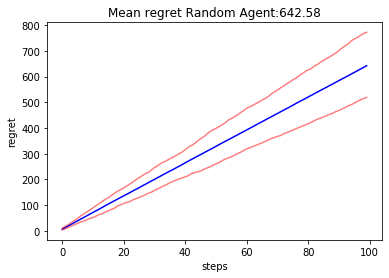

In [31]:
random_agent = Random(nb_items,nb_actions=nb_actions,seed=2020)
#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"random")
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"Random Agent")

#2-EPSILON-GREEDY AGENT

In [0]:
class EpsilonGreedy:
    """ Epsilon greedy agent. """
    def __init__(self, nb_items,nb_actions, epsilon=0, seed=None):
        self._nb_items = nb_items
        self._nb_actions = nb_actions
        self._epsilon = epsilon
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(nb_items)
        self._n = np.zeros(nb_items)
        
    def act(self,context):
        if self._rng.random() < self._epsilon:
            actions = sample_without_replacement(n_population = self._nb_items-1, n_samples = self._nb_actions)
        else:
            actions = get_best_actions(self._q,self._nb_actions)
        return actions
        
    def update(self, context,actions, rewards):
      for action in actions:
        self._n[action] += 1
        self._q[action] += (rewards[action] - self._q[action])/self._n[action]

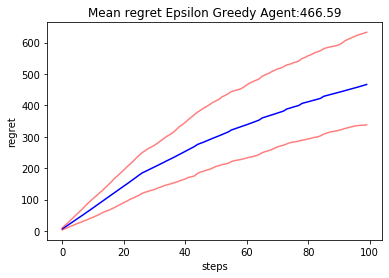

In [33]:
epsilon = 0.1
epsilon_agent = EpsilonGreedy(nb_items=nb_items,nb_actions=nb_actions,epsilon=epsilon,seed=2020)
#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"epsilon_greedy")
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"Epsilon Greedy Agent")

#3-Deep recommender Agent

In [34]:
#generate historical data as a reward matrix

exp = run_exp(random_agent,amazon_env, 1000, env_seed=2020)
np.where(exp["history_matrix"] != 0)[0].shape



(3357,)

In [35]:
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout, Concatenate 
from tensorflow.keras.layers import Dot
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import copy

In [36]:
# For each sample we input the integer identifiers
# of a single user and a single item
class DeepRegressionModel(Model):

    def __init__(self, embedding_size, max_user_id, max_item_id):
        super().__init__()

        self.user_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_user_id + 1,
            input_length=1,
            name='user_embedding'
        )
        self.item_embedding = Embedding(
            output_dim=embedding_size,
            input_dim=max_item_id + 1,
            input_length=1,
            name='item_embedding'
        )

        # The following two layers don't have parameters.
        self.flatten = Flatten()
        self.concat = Concatenate()

        
        self.dropout = Dropout(0.5)
        self.dense1 = Dense(64, activation="relu")
        self.dense2 = Dense(1)

    def call(self, inputs, training=False):
        user_inputs = inputs[0]
        item_inputs = inputs[1]

        user_vecs = self.flatten(self.user_embedding(user_inputs))
        item_vecs = self.flatten(self.item_embedding(item_inputs))

        input_vecs = self.concat([user_vecs, item_vecs])

        y = self.dropout(input_vecs, training=training)
        y = self.dense1(y)
        y = self.dropout(y, training=training)
        y = self.dense2(y)

        return y


    
max_user_id = amazon_env.nb_users
max_item_id = amazon_env.nb_items  
model = DeepRegressionModel(36, max_user_id, max_item_id)
model.compile(optimizer='adam', loss='mse', metrics =['accuracy'])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [37]:
history_matrix = exp["history_matrix"]
user_ids, item_ids = np.where(history_matrix != 0)
user_id_train, user_id_test, item_id_train, item_id_test  = train_test_split(user_ids, item_ids, test_size=0.1, random_state=0)

rewards_train = history_matrix[user_id_train, item_id_train]
rewards_test = history_matrix[user_id_test, item_id_test]

print(rewards_train.shape)
print(rewards_test.shape)

(3021,)
(336,)


In [38]:
model.fit([user_id_train, item_id_train], rewards_train,
                    batch_size=64, epochs=100, validation_split=0.0,
                    shuffle=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 3021 samples
Epoch 1/100
3021/3021 [==============================] - 2s 605us/sample - loss: 1.8087 - acc: 0.0000e+00
Epoch 2/100
3021/3021 [==============================] - 0s 48us/sample - loss: 0.5490 - acc: 0.0000e+00
Epoch 3/100
3021/3021 [==============================] - 0s 52us/sample - loss: 0.2349 - acc: 0.0000e+00
Epoch 4/100
3021/3021 [==============================] - 0s 57us/sample - loss: 0.2049 - acc: 0.0000e+00
Epoch 5/100
3021/3021 [==============================] - 0s 53us/sample - loss: 0.1975 - acc: 0.0000e+00
Epoch 6/100
3021/3021 [==============================] - 0s 49us/sample - loss: 0.1865 - acc: 0.0000e+00
Epoch 7/100
3021/3021 [==============================] - 0s 52us/sample - loss: 0.1891 - acc: 0.0000e+00
Epoch 8/100
3021/3021 [==============================] - 0s 48us/sample - loss: 0.1793 - acc: 0.0000e+00
Epoch 9/100
3021/3021 [==============================] -

In [39]:
predictions = model.predict([user_id_test, item_id_test])
mean_squared_error(predictions,rewards_test)

0.10864943543206497

In [40]:
estimated_rewards = copy.deepcopy(history_matrix)

for i in range(estimated_rewards.shape[0]) : 
    for j in range(estimated_rewards.shape[1]) :
        if estimated_rewards[i,j] == 0 :
            estimated_rewards[i,j] = model.predict([[i],[j]])

print(history_matrix)
print(estimated_rewards)


[[0.   1.39 0.   ... 0.23 2.39 0.  ]
 [0.   0.   1.35 ... 0.22 2.47 0.  ]
 [0.   1.67 0.66 ... 0.21 2.35 0.  ]
 ...
 [1.08 1.88 0.   ... 0.23 1.5  0.  ]
 [0.   2.   0.   ... 0.   3.02 0.  ]
 [0.   1.5  0.   ... 0.2  0.   0.  ]]
[[0.79 1.39 0.94 ... 0.23 2.39 1.37]
 [0.86 1.59 1.35 ... 0.22 2.47 1.62]
 [0.8  1.67 0.66 ... 0.21 2.35 1.55]
 ...
 [1.08 1.88 1.24 ... 0.23 1.5  1.73]
 [0.94 2.   1.36 ... 0.36 3.02 1.85]
 [0.8  1.5  1.   ... 0.2  2.22 1.52]]


In [0]:
class DeepRecommenderAgent:
    """ Deep Recommender agent. """
    def __init__(self, nb_items, nb_users, nb_actions, est_rewards, seed=None):
        self.est_rewards = est_rewards
        self.nb_items = nb_items
        self.nb_users = nb_users
        self.nb_actions = nb_actions
        self.history = np.zeros((nb_users,nb_items))
        self.t = 0
        

        
    def act(self, context):
        user = context[0][0]
        items_rewards = self.est_rewards[user,:]
        actions = get_best_actions(items_rewards,nb_actions)
        self.t +=1
        return actions
        
    def update(self, context, actions, rewards):
        # Save history.
        user = context[0][0]
        self.history[user,actions] = rewards[actions]

        #Train again to update the estimated_reward matrix used by the agent 
        freq = 150      #change here to update more frequently
        if self.t %freq == 0:    
          history_matrix = self.history
          user_ids, item_ids = np.where(history_matrix != 0)
          user_id_train, user_id_test, item_id_train, item_id_test  = train_test_split(user_ids, item_ids, test_size=0.1, random_state=0)
          rewards_train = history_matrix[user_id_train, item_id_train]
          rewards_test = history_matrix[user_id_test, item_id_test]

          max_user_id = self.nb_users
          max_item_id = self.nb_items  
          model = DeepRegressionModel(36, max_user_id, max_item_id)
          model.compile(optimizer='adam', loss='mse', metrics =['accuracy'])

          model.fit([user_id_train, item_id_train], rewards_train,
                    batch_size=64, epochs=50, validation_split=0.0,
                    shuffle=True, verbose=0)
          
          predictions = model.predict([user_id_test, item_id_test])
          estimated_rewards = copy.deepcopy(history_matrix)

          for i in range(estimated_rewards.shape[0]) : 
                for j in range(estimated_rewards.shape[1]) :
                    if estimated_rewards[i,j] == 0 :
                        estimated_rewards[i,j] = model.predict([[i],[j]])
          
          self.est_rewards = estimated_rewards
          

        pass

In [0]:
deep_agent = DeepRecommenderAgent(nb_items, nb_users, nb_actions, estimated_rewards)

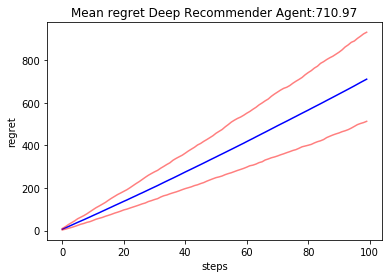

In [43]:
#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"deep_recommender",nb_items=nb_items,nb_actions=nb_actions,nb_users=nb_users,epsilon=0.1,estimated_rewards=estimated_rewards)
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"Deep Recommender Agent")

#4-Thompson Agent

In [0]:
class ThompsonAgent():
    
  def __init__(self, T,d, delta, eps, items, nb_actions):
    self.T = 0
    self.d = d
    self.delta = delta
    self.eps = eps
    self.B = np.identity(self.d)
    self.invB = np.identity(self.d)
    self.beta = np.zeros(self.d)
    self.f = np.zeros(self.d)
    self.v = np.sqrt(24*self.d*np.log(1/self.delta)/self.eps)
    self.items = items
    self.nb_actions = nb_actions
    pass

  def act(self,context):
    beta = np.random.multivariate_normal(self.beta, (self.v**2)*self.invB)
    func = [ np.dot(a,self.beta) for a in self.items]
    chosen_actions = get_best_actions(func,nb_actions)
        
    return chosen_actions
            


  def update(self, context, actions, rewards):
    for chosen_action in actions:
        arm_vec = self.items[chosen_action][:,np.newaxis]
        self.B += np.dot(arm_vec,arm_vec.T)
        self.invB = np.linalg.inv(self.B)
        self.f += rewards[chosen_action]*self.items[chosen_action]
        self.beta = np.dot(self.invB,self.f)

    pass


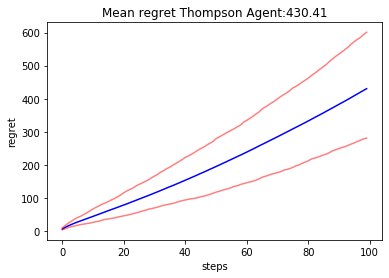

In [45]:
eps = 0.01
items = amazon_env.items_embedding
#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"thompson",d=d,delta=delta,items=items, eps=eps)
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"Thompson Agent")

#5-LinUCB Agent

In [0]:
class LinUCBAgent():

  def __init__(self, T, d, delta, nb_items,nb_actions, items, params=None):
    self.T = T
    self.d = d
    self.params = params
    self.delta = delta
    self.t = 0
    self.covariance = np.identity(d)
    self.sumAX = np.zeros(d)
    self.theta = np.zeros(d)
    self.invCov = np.identity(d)
    self.items = items
    self.nb_items = nb_items
    self.nb_actions = nb_actions

  def act(self,context ):
    
    beta = 1 + np.sqrt(2*np.log(1/delta) + self.d*np.log(1+self.t/self.d))
    func = [np.dot(a,self.theta) + np.sqrt(beta*np.dot(a.dot(self.invCov),a)) for a in self.items]
    chosen_actions = get_best_actions(func,nb_actions)
        
    return chosen_actions
    

  def update(self, context, actions, rewards):
    arm_vec = self.items[:,np.newaxis]

    for chosen_action in actions:
      #The following line is the implementation of the Sherman-Morrison formula 
      arm_vec = self.items[chosen_action][:,np.newaxis]
      self.invCov -= np.dot(self.invCov, (arm_vec.dot(arm_vec.T)).dot(self.invCov)) /(1+np.dot(arm_vec.T,self.invCov.dot(arm_vec)))

      #Uncomment the two following lines to use a direct invertion with np.linalg.inv
      #self.covariance += np.dot(arm_vec,arm_vec.T)
      #self.invCov = np.linalg.inv(self.covariance)

    for chosen_action in actions:
      chosen_item = self.items[chosen_action] 
      self.sumAX += rewards[chosen_action]*chosen_item

    self.theta = np.dot(self.invCov, self.sumAX)
    self.t +=1

    pass






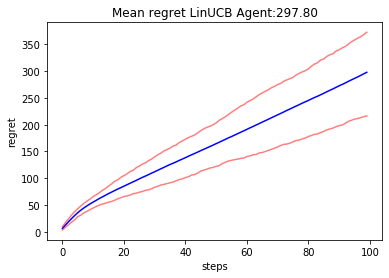

In [47]:
d = amazon_env.internal_embedding_size
items = amazon_env.items_embedding
delta = 0.1
linUCB_agent = LinUCBAgent(nb_steps, d,delta, nb_items, nb_actions,items)

#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"linUCB",d=d,delta=delta,items=items)
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"LinUCB Agent")

#6-UCB Agent

In [0]:
class UCB:
    """ Upper Confidence Bound agent. """

    def __init__(self, nb_items, c=2,nb_actions=5,seed=None):
        self.nb_items = nb_items
        self.nb_actions = nb_actions
        self._c = c
        self._rng = np.random.RandomState(seed)
        self._q = np.zeros(nb_items)
        self._n = np.zeros(nb_items)
        self._t = 0
        
    def act(self,actions):

        non_played_actions = np.where(self._n==0)[0] #get the list of non played actions
        # print(non_played_actions)
        if len(non_played_actions) >= self.nb_actions:
            """ Play each action at least once. """
            
            actions = np.random.choice(non_played_actions,self.nb_actions,replace=False)
            # sample_without_replacement(n_population = np.where(self._n==0)[0], n_samples = self.nb_actions)
        else:
            actions = get_best_actions(self._q,self.nb_actions)
            # action = np.argmax(self._q +  np.sqrt(self._c * np.log(self._t) / self._n))
            
        return actions
        
    def update(self, context,actions, rewards):

        for action in actions:
          self._n[action] += 1
          self._q[action] += (rewards[action] - self._q[action])/self._n[action]

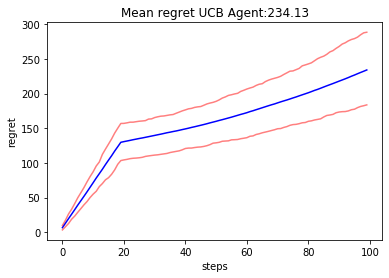

In [49]:
#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"ucb",nb_items=nb_items)
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"UCB Agent")

#NOTE



**From the previous graph, UCB seems to be the best agent. We will compare below UCB and LinUCB for more items.**

In [0]:
nb_items = 500
nb_users = 100
nb_actions = 5

amazon_env = Amazon_environment(nb_users=nb_users,nb_items=nb_items,items_featues=2,internal_embedding_size=36,nb_actions=nb_actions,displayed_items_embedding_size=2)
  

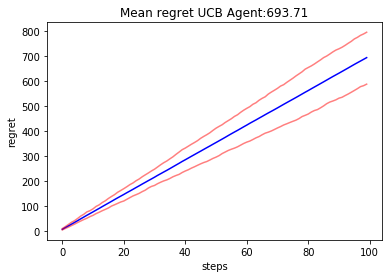

In [51]:
#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"ucb",nb_items=nb_items)
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"UCB Agent")

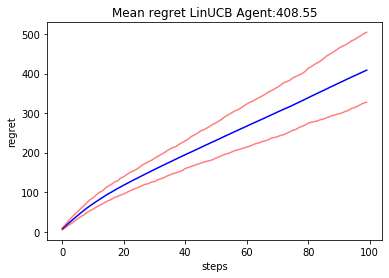

In [52]:
d = amazon_env.internal_embedding_size
items = amazon_env.items_embedding
delta = 0.1
linUCB_agent = LinUCBAgent(nb_steps, d,delta, nb_items, nb_actions,items)

#run monte carlo estimation
regrets,regret = monte_carlo_estimation(nb_exp,nb_steps,amazon_env,"linUCB",d=d,delta=delta,items=items)
#plot the graph of the cumulative regret 
plot_regret(regrets,regret,low_ci,high_ci,"LinUCB Agent")

**As we can see, when we increase the number of items, UCB actually performs bad because it explores a lot with respect to LinUCB which has better results. In conclusion, LinUCB is the best Agent for our environment.**